# HSCT survival: linear regression model

## Notebook set-up

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

import configuration as config
import functions.helper as helper_funcs

# Data files
training_features_df_file=f'{config.DATA_PATH}/processed/02.1-scaled_encoded_training_features_df.parquet'
training_labels_df_file=f'{config.DATA_PATH}/processed/02.1-scaled_encoded_training_labels_df.parquet'
testing_features_df_file=f'{config.DATA_PATH}/processed/02.1-scaled_encoded_testing_features_df.parquet'
poly_features_data_file=f'{config.DATA_PATH}/processed/03.1-polynomial_training_features_df.parquet'

# Model files
model_file=f'{config.MODELS_PATH}/03.1-linear_regression.pkl'
poly_model_file=f'{config.MODELS_PATH}/03.1-linear_regression_polynomial_features.pkl'
poly_features_transformer_file=f'{config.MODELS_PATH}/03.1-poly_features_transformer.pkl'

retrain_models=False
rebuild_poly_features=False

## 1. Load data

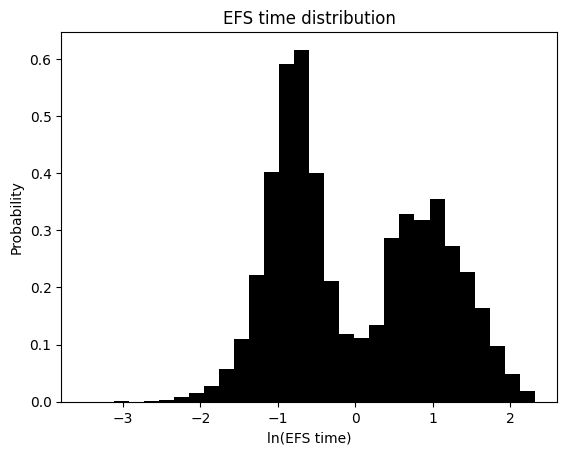

Training features: (28800, 178)


In [2]:
training_features=pd.read_parquet(training_features_df_file)
training_labels=pd.read_parquet(training_labels_df_file)

# Remove id column from training features
training_features.drop('ID', axis=1, inplace=True)

plt.title('EFS time distribution')
plt.hist(training_labels['efs_time'], density=True, bins=30, color='black')
plt.xlabel('ln(EFS time)')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {training_features.shape}')

## 2. Linear regression model

### 2.1. Cross-validation

In [3]:
# Instantiate default linear regression model
model=LinearRegression()

# Run cross-validation to estimate out-of-sample performance
scores=helper_funcs.cross_val(model, training_features, training_labels['efs_time'])

Cross validation RMSE 0.92 +/- 0.01


### 2.2. Training set performance

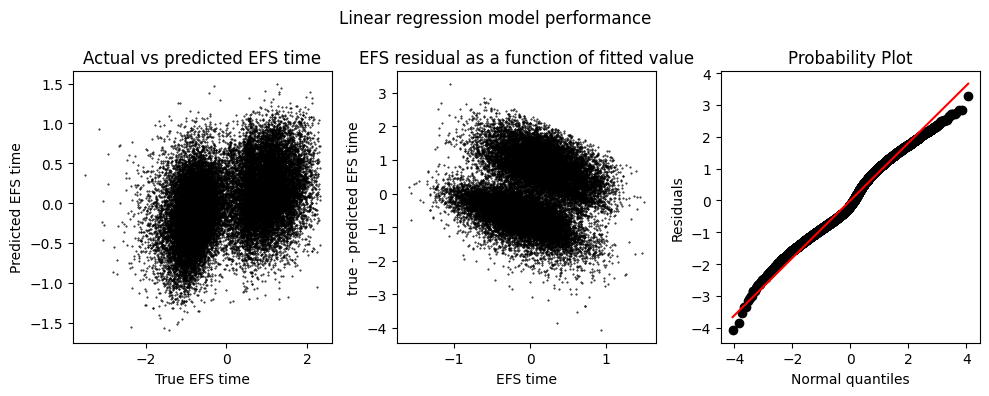

In [4]:
# Train or load model as desired
if retrain_models == True:
    model.fit(training_features, training_labels['efs_time'])

    with open(model_file, 'wb') as output_file:
        pickle.dump(model, output_file)

elif retrain_models == False:
    with open(model_file, 'rb') as input_file:
        model=pickle.load(input_file)

# Make predictions for the whole training set
predicted_efs_time=model.predict(training_features)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(
    predicted_efs_time, 
    training_labels['efs_time'] - predicted_efs_time,
    color='black',
    s=0.2
)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(training_labels['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 3. Linear regression: polynomial features

### 3.1. Make/load polynomial features

In [5]:
# Build or load polynomial features as desired
if rebuild_poly_features == True:

    poly=PolynomialFeatures(2)
    poly.fit(training_features)
    training_data=poly.transform(training_features)

    with open(poly_features_transformer_file, 'wb') as output_file:
        pickle.dump(poly, output_file)

    poly_features_df=pd.DataFrame(training_data)
    poly_features_df.to_parquet(poly_features_data_file)

elif rebuild_poly_features == False:

    poly_features_df=pd.read_parquet(poly_features_data_file)

    with open(poly_features_transformer_file, 'rb') as input_file:
        poly=pickle.load(input_file)

### 3.2. Fit/load polynomial features regression model

In [6]:
# Train or load model as desired
if retrain_models == True:
    poly_model=LinearRegression()
    poly_model.fit(training_features, training_labels['efs_time'])

    # Run cross-validation to estimate out-of-sample performance
    scores=helper_funcs.cross_val(poly_model, poly_features_df, training_labels['efs_time'])

    with open(poly_model_file, 'wb') as output_file:
        pickle.dump(poly_model, output_file)

elif retrain_models == False:
    with open(poly_model_file, 'rb') as input_file:
        poly_model=pickle.load(input_file)

### 3.4. Training set performance

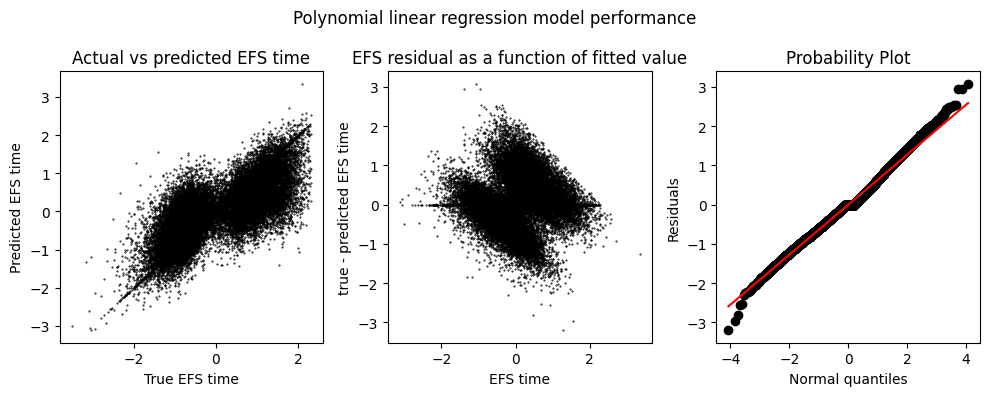

In [7]:
# Make predictions on the training set
predicted_efs_time=poly_model.predict(poly_features_df)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Polynomial linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(
    predicted_efs_time,
    training_labels['efs_time'] - predicted_efs_time,
    color='black',
    s=0.2
)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(training_labels['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 4. Make test set predictions

In [9]:
testing_features_df=pd.read_parquet(testing_features_df_file)
ids=testing_features_df['ID']
testing_features_df.drop('ID', axis=1, inplace=True)
poly_testing_features_df=poly.transform(testing_features_df)
predicted_efs_time=poly_model.predict(poly_testing_features_df)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict(
    {'ID': ids, 'prediction': predicted_efs_time.flatten()}
)

predictions_df.describe()

,ID,prediction
count,3.0,3.000000
mean,28801.0,0.343751
std,1.0,0.568543
min,28800.0,0.000000
25%,28800.5,0.015626
50%,28801.0,0.031253
75%,28801.5,0.515626
max,28802.0,1.000000
